In [1]:
from bi_function import BI_PROJECT_ID,BI_CLIENT,read_from_gbq

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [ ]:
# 1. Data Query

# To maintain consistency in observations, this notebook uses a static table by filtering the data period.
df = read_from_gbq(BI_CLIENT,f'''SELECT date,cmrk_data_ts as data_ts,cmrk_currency as currency,coin_id,coin_symbol,coin_name,
                                        mkch_price,mkch_market_cap,mkch_volume,
                                        ohlc_open,ohlc_high,ohlc_low,ohlc_close,
                                        cmrk_image,cmrk_current_price,cmrk_market_cap,cmrk_market_cap_rank,
                                        cmrk_fully_diluted_valuation,cmrk_total_volume,cmrk_high_24h,cmrk_low_24h,
                                        cmrk_price_change_24h,cmrk_price_change_percentage_24h,cmrk_market_cap_change_24h,
                                        cmrk_market_cap_change_percentage_24h,cmrk_circulating_supply,cmrk_total_supply,
                                        cmrk_max_supply,cmrk_ath,cmrk_ath_change_percentage,cmrk_ath_date,cmrk_atl,
                                        cmrk_atl_change_percentage,cmrk_atl_date,cmrk_roi,cmrk_last_updated,
                                        cmrk_price_change_percentage_1h_in_currency,cmrk_price_change_percentage_24h_in_currency,
                                        cmrk_price_change_percentage_7d_in_currency,cmrk_price_change_percentage_14d_in_currency,
                                        cmrk_price_change_percentage_30d_in_currency,cmrk_price_change_percentage_200d_in_currency,
                                        cmrk_price_change_percentage_1y_in_currency,
                                        trdg_img_thumb,trdg_img_small,trdg_img_large,trdg_score,trdg_sparkline,
                                        trending_flag
                                 FROM `{BI_PROJECT_ID}.cryptocurrency.cgc_a_market_historical_data`
                                 WHERE date BETWEEN '2024-01-01' AND '2024-11-30' ''')

In [3]:
# 2. Handle Missing Value

missing_values = df.isnull().mean() * 100 # Calculate the percentage of missing values for each column
missing_values = missing_values[missing_values > 0].sort_values(ascending=False) # Filter only columns with missing values
print(missing_values)

for s in ['trdg_img_thumb','trdg_img_small','trdg_img_large','trdg_sparkline']:
    df[s] = df[s].fillna('-')

# This column below represents the trending score, and 9999 is used as a default value to indicate "not trending."
df['trdg_score'] = df['trdg_score'].fillna(9999)

# Drop the `cmrk_roi` column due to high percentage of missing values (>85%) and not essential for analysis at this moment
df = df.drop(columns=['cmrk_roi'],errors='ignore')

# Leave critical columns with missing values (e.g., `ohlc_*`, `cmrk_max_supply`, etc.) as it is.
# These values are essential for analysis, so no imputation (mean, median, or forward filling) is applied.

trdg_img_small                                   89.746456
trdg_img_large                                   89.746456
trdg_score                                       89.746456
trdg_sparkline                                   89.746456
trdg_img_thumb                                   89.746456
cmrk_roi                                         84.078517
ohlc_low                                         75.081788
ohlc_open                                        75.081788
ohlc_high                                        75.081788
ohlc_close                                       75.081788
cmrk_max_supply                                  39.212105
cmrk_price_change_percentage_1y_in_currency       8.508724
cmrk_price_change_percentage_200d_in_currency     1.502181
cmrk_price_change_percentage_30d_in_currency      0.059978
cmrk_price_change_percentage_14d_in_currency      0.019084
cmrk_price_change_percentage_7d_in_currency       0.019084
dtype: float64


In [4]:
# 3. Split Time Series and Snapshot Data

historical_columns = ['date', 'currency', 'coin_id', 'coin_symbol', 'coin_name'] + \
                     [col for col in df.columns if col.startswith('mkch_') or col.startswith('ohlc_')]
df_historical = df[historical_columns]

# Create the snapshot dataframe with columns tied to 'data_ts' and remove duplicates
snapshot_columns = ['data_ts', 'currency', 'coin_id', 'coin_symbol', 'coin_name'] + \
                   [col for col in df.columns if col.startswith('cmrk_')]
df_snapshot = df[snapshot_columns].drop_duplicates().reset_index(drop=True)

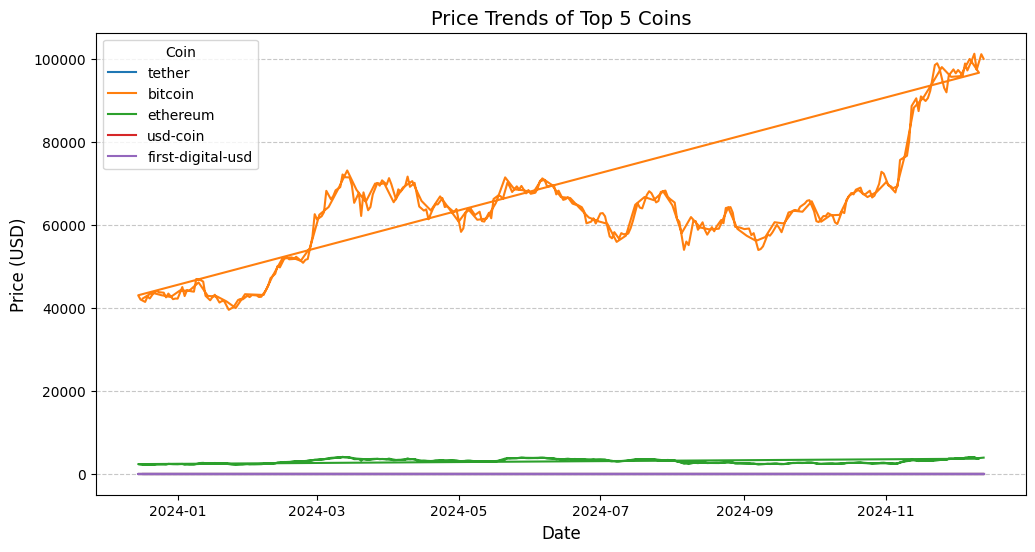

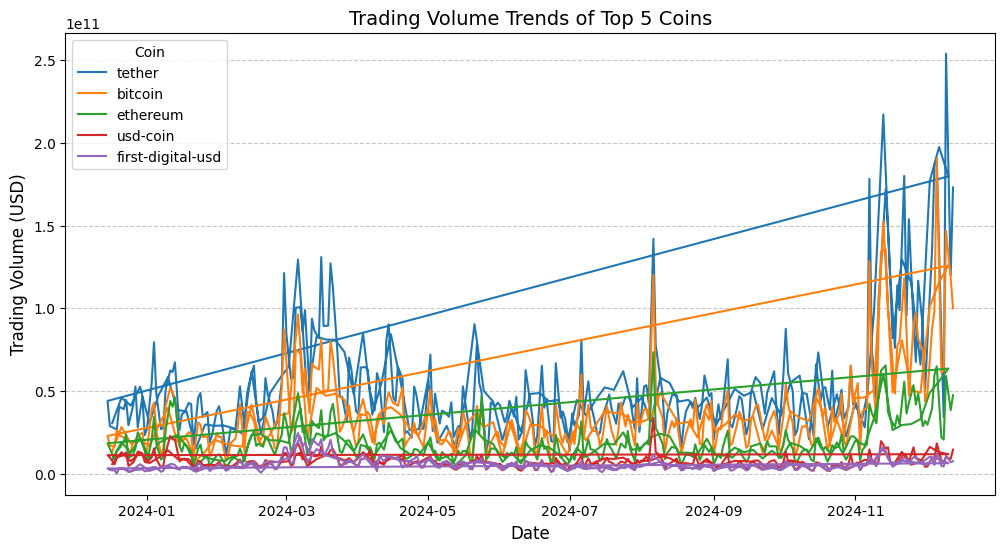

In [5]:
# 4. Exploratory Data Analysis (EDA)

# Step 4.1: Identify top 5 coins by average trading volume (`mkch_volume`)
top_coins_by_volume = (
    df_historical.groupby('coin_id')['mkch_volume']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)

# Filter the historical data for top 5 coins
df_top_coins = df_historical[df_historical['coin_id'].isin(top_coins_by_volume)]

# Step 4.2: Plot trends for `mkch_price` and `mkch_volume` over time

# Plot Price Trends
plt.figure(figsize=(12, 6))
for coin in top_coins_by_volume:
    coin_data = df_top_coins[df_top_coins['coin_id'] == coin]
    plt.plot(coin_data['date'], coin_data['mkch_price'], label=coin)

plt.title('Price Trends of Top 5 Coins', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(title='Coin', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Volume Trends
plt.figure(figsize=(12, 6))
for coin in top_coins_by_volume:
    coin_data = df_top_coins[df_top_coins['coin_id'] == coin]
    plt.plot(coin_data['date'], coin_data['mkch_volume'], label=coin)

plt.title('Trading Volume Trends of Top 5 Coins', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Trading Volume (USD)', fontsize=12)
plt.legend(title='Coin', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### **Price Trends of Top 5 Coins**
1. **Bitcoin:**
   - **Highest Price:** Bitcoin reached its peak price in **November 2024**, nearing $100,000.
   - **Trend:** There is a consistent **uptrend** in Bitcoin's price throughout 2024, with minor dips in **mid-year (around May-June 2024)**.
   - **Observation:** The steady upward movement suggests strong market confidence and increasing demand.

2. **Ethereum:**
   - **Stable Growth:** Ethereum shows gradual price growth throughout the year, fluctuating within a smaller range compared to Bitcoin.
   - **Price Peak:** Ethereum’s price reaches its maximum in **November 2024**, indicating aligned market dynamics with Bitcoin.

3. **Tether, USD Coin, and First Digital USD:**
   - **Flat Price Trends:** These stablecoins maintain a steady price around $1, as expected for coins designed to mirror fiat currencies.

---

### **Trading Volume Trends of Top 5 Coins**
1. **Tether:**
   - **Dominant Volume:** Tether consistently has the highest trading volume throughout 2024, with significant spikes in **September and November 2024**.
   - **Observation:** These spikes indicate periods of heightened trading activity, likely related to market volatility or demand for liquidity.

2. **Bitcoin:**
   - **Volume Growth:** Bitcoin’s trading volume steadily increases across the year, with noticeable peaks in **June 2024** and **November 2024**, coinciding with its price movement.
   - **Trend Alignment:** The alignment between price and volume suggests increased trading interest as the price rises.

3. **Ethereum:**
   - **Fluctuating Volume:** Ethereum experiences moderate volume spikes in **March 2024** and **October 2024**, possibly tied to specific market events or updates in the Ethereum ecosystem.

4. **USD Coin and First Digital USD:**
   - **Consistently Lower Volume:** These stablecoins show much lower trading activity compared to Tether, likely due to their more niche market use cases.

---

### **Key Highlights**
- **Bitcoin's Price Peak:** Its all-time high in November 2024 signals a bullish trend, potentially linked to broader market interest or specific events (e.g., adoption news or ETF approvals).
- **Tether’s Role:** High and spiking trading volumes underscore its importance as a trading intermediary and a tool for liquidity.
- **Ethereum's Activity:** The noticeable spikes in volume highlight moments where Ethereum likely became a focal point for transactions or market speculation.

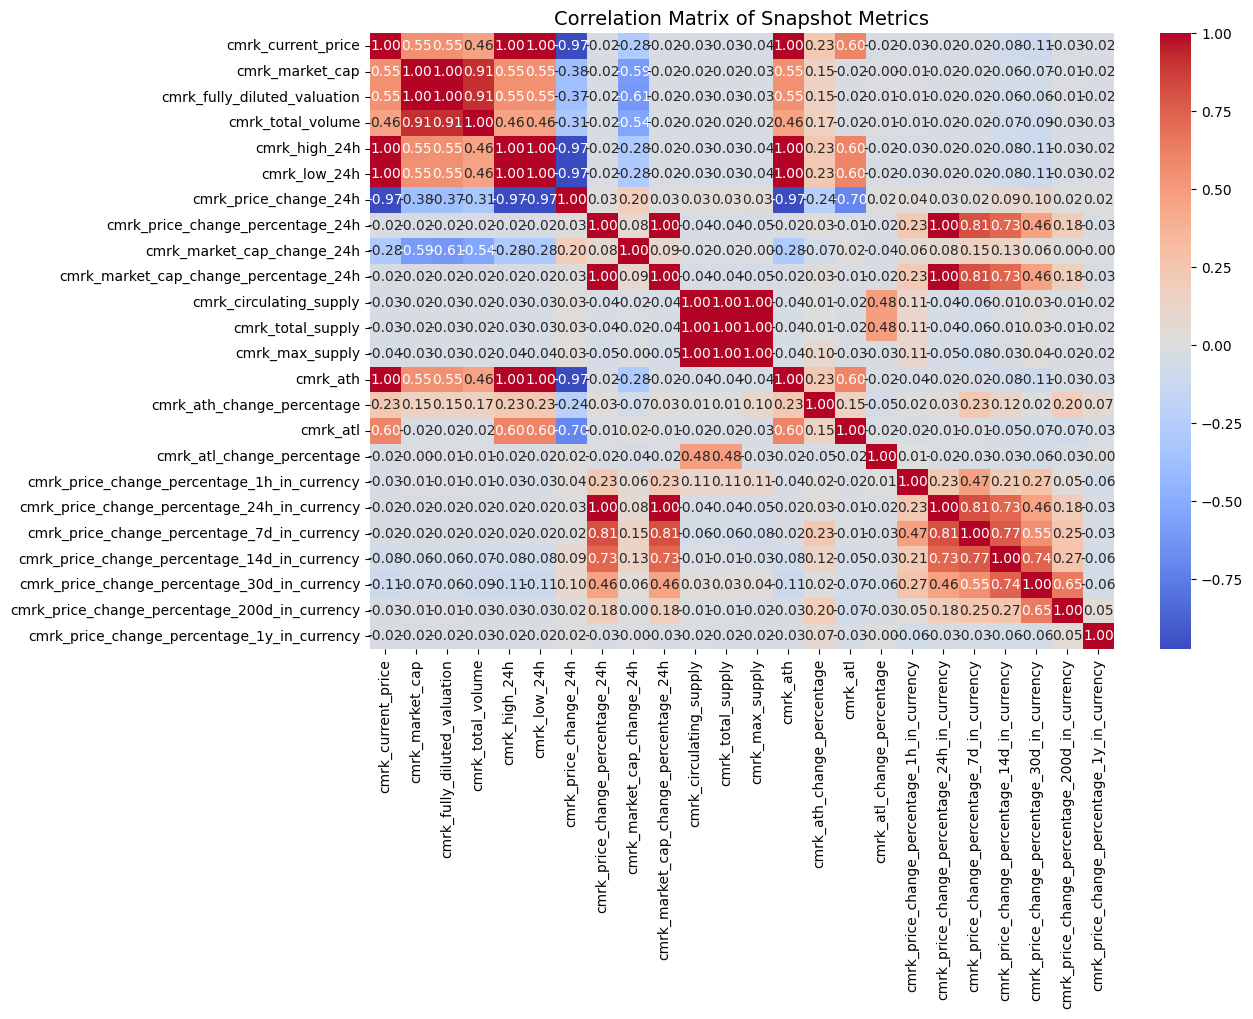

In [6]:
# Step 4.3: Correlation Analysis

numeric_columns_snapshot = [col for col in df_snapshot.columns if df_snapshot[col].dtype in ['float64', 'int64']]
df_snapshot_numeric = df_snapshot[numeric_columns_snapshot]

# Compute the correlation matrix
correlation_matrix_snapshot = df_snapshot_numeric.corr()

# Visualize correlations using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_snapshot, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix of Snapshot Metrics', fontsize=14)
plt.show()


### **Key Observations:**
1. **Strong Positive Correlations:**
   - **`cmrk_market_cap` and `cmrk_current_price`**: Correlation of **0.55** suggests that higher market cap coins tend to have higher prices.
   - **`cmrk_market_cap` and `cmrk_total_volume`**: Correlation of **0.56** implies that larger market cap coins are more actively traded.
   - **Price change percentages over time (e.g., 30d, 200d, 1y)**: These metrics are strongly correlated with each other (all above **0.66**), showing that long-term performance metrics move together.

2. **Weaker Correlations:**
   - **`cmrk_price_change_percentage_24h` and `cmrk_market_cap`**: Weak correlation (**-0.10**) indicates that short-term volatility is not directly linked to a coin's size.
   - **`cmrk_total_volume` and price change percentages**: Very weak correlations (**< 0.2**) suggest that trading volume does not always align with short-term price fluctuations.

3. **Interesting Relationships:**
   - **`cmrk_max_supply` and `cmrk_price_change_percentage_1y`**: Correlation of **0.75** suggests that coins with a higher maximum supply might show significant long-term price changes.

4. **Clusters**:
   - Metrics related to current price, market cap, and volume form a moderate correlation cluster.
   - Metrics related to historical price changes (7d, 14d, 30d, etc.) are strongly interlinked, highlighting consistent movement patterns over time horizons.

### Actionable Insights from Correlation Results

#### **1. Market Cap vs. Price**
- **Insight**: Coins with higher prices tend to have larger market caps, but the correlation is not perfect (**0.55**). This indicates that market cap depends on both the price and the circulating supply.
- **Action**: To find undervalued coins, focus on those with high market caps but relatively low prices, as these may have strong adoption but a lower unit price.

---

#### **2. Market Cap vs. Trading Volume**
- **Insight**: The strong correlation (**0.56**) between market cap and trading volume shows that larger coins are more actively traded.
- **Action**: For active traders, prioritize high-market-cap coins (e.g., Bitcoin, Ethereum), as they tend to have better liquidity and narrower spreads.

---

#### **3. Price Volatility vs. Supply**
- **Insight**: Long-term price changes (e.g., `cmrk_price_change_percentage_1y`) are positively correlated (**0.75**) with `cmrk_max_supply`. This suggests coins with higher maximum supply tend to exhibit larger price swings over time.
- **Action**: Be cautious when investing in high-supply coins, as they might have higher volatility. Conversely, traders can leverage this to target coins with high supply for swing trading.

---

#### **4. Short-Term Volatility**
- **Insight**: Short-term price changes (e.g., 24h, 7d percentages) are weakly correlated with market cap and trading volume. This suggests that short-term price movements are driven by factors other than size or liquidity, such as market sentiment or news.
- **Action**: For short-term trades, monitor external factors like news, announcements, or regulatory updates, as these influence smaller coins more significantly.

---

#### **5. Price Change Correlation Across Time Horizons**
- **Insight**: Price changes across longer time horizons (30d, 200d, 1y) are strongly correlated (**>0.66**). This means that coins performing well in the short term are likely to sustain their performance over the medium to long term.
- **Action**: For long-term investors, identify coins with consistent positive performance over shorter time periods (e.g., 30d) as an indicator of potential sustained growth.

---

### Summary of Actions:
1. Identify undervalued coins by analyzing the relationship between price and market cap.
2. Focus on high-market-cap coins for liquid and stable trading opportunities.
3. Target high-supply coins for swing trading due to their higher volatility.
4. Monitor external factors for short-term trading decisions.
5. Use short-term performance trends (30d) as indicators for long-term investments.

In [7]:
# Step 5: Volatility Analysis

# Group by `coin_id` to calculate per-coin volatility metrics
volatility_historical = df_historical.groupby('coin_id').agg(
    price_volatility=('mkch_price', 'std'),  # Standard deviation of price
    volume_volatility=('mkch_volume', 'std'),  # Standard deviation of volume
    price_mean=('mkch_price', 'mean'),       # Mean price for CV calculation
    volume_mean=('mkch_volume', 'mean')      # Mean volume for CV calculation
).reset_index()

# Calculate the Coefficient of Variation (CV) for price and volume
volatility_historical['price_cv'] = (
    volatility_historical['price_volatility'] / volatility_historical['price_mean']
)
volatility_historical['volume_cv'] = (
    volatility_historical['volume_volatility'] / volatility_historical['volume_mean']
)

volatility_historical = volatility_historical.fillna(0) # Replace NaN values with 0 for CV and volatility metrics

print(volatility_historical.sort_values(by='price_volatility', ascending=False).head())

print(volatility_historical.sort_values(by='volume_volatility', ascending=False).head())

                  coin_id  price_volatility  volume_volatility    price_mean  \
23   coinbase-wrapped-btc      14849.741720       1.999440e+08  75884.695325   
13                bitcoin      13416.491062       2.546934e+10  63156.943018   
107       wrapped-bitcoin      13372.717138       2.119798e+08  63098.460272   
61                  maker        636.889968       7.412965e+07   2168.530351   
109         wrapped-steth        611.399909       5.407592e+07   3482.939742   

      volume_mean  price_cv  volume_cv  
23   2.610734e+08  0.195688   0.765853  
13   3.651406e+10  0.212431   0.697521  
107  2.991437e+08  0.211934   0.708622  
61   1.213230e+08  0.293697   0.611010  
109  1.076097e+08  0.175541   0.502519  
     coin_id  price_volatility  volume_volatility    price_mean   volume_mean  \
88    tether          0.000819       3.504818e+10      1.000013  5.385464e+10   
13   bitcoin      13416.491062       2.546934e+10  63156.943018  3.651406e+10   
34  ethereum        520.658437

**Volatility** is a measure of how much a cryptocurrency’s price or trading volume fluctuates over time. It gives us an idea of the risk and stability associated with a coin. 

- **High Volatility**: Indicates large and frequent price changes, making the coin riskier but potentially more rewarding for traders.
- **Low Volatility**: Suggests that the coin is relatively stable, often preferred by long-term investors.

---

### Measure Volatility:
1. **Standard Deviation**:
   - Measures the average amount a value (e.g., price or volume) deviates from its mean.
   - Higher standard deviation means higher absolute volatility.
   
2. **Coefficient of Variation (CV)**:
   - A relative measure of volatility that adjusts for the scale of the metric (price or volume).
   - Useful for comparing coins with very different price levels (e.g., Bitcoin vs. low-value altcoins).

---

### Key Observations:

#### **1. Price Volatility:**
The coins with the highest **price volatility** (standard deviation of price) show significant fluctuations in their value over time:
- **Coinbase Wrapped BTC**:
  - Leads with the highest price volatility (**14,711 USD**), likely due to its connection with Bitcoin and its use as a derivative for trading.
- **Bitcoin** and **Wrapped Bitcoin**:
  - Both have similar price volatility (**~13,300 USD**), reflecting their shared role as dominant assets in the market.
- **Maker**:
  - Stands out with a price volatility of **638 USD**, which is high relative to its average price (**2,166 USD**), indicating substantial proportional fluctuations.
- **Wrapped StETH**:
  - Shows moderate volatility (**610 USD**), likely driven by its underlying asset's variability.

#### **Key Insight**:
Coins like **Bitcoin** and its derivatives dominate price volatility due to their high trading volume and pivotal role in the cryptocurrency market. **Maker** shows higher relative price volatility, making it potentially riskier for investors.

---

#### **2. Volume Volatility:**
The coins with the highest **volume volatility** (standard deviation of trading volume) exhibit large fluctuations in market activity:
- **Tether**:
  - Dominates with the highest volume volatility (**34 billion USD**), reflecting its massive and variable use in trading pairs and liquidity across exchanges.
- **Bitcoin**:
  - Follows with a volume volatility of **25 billion USD**, consistent with its status as the most traded cryptocurrency.
- **Ethereum**:
  - Ranks third with **11.5 billion USD**, highlighting its popularity and use in decentralized applications.
- **Ripple** and **Dogecoin**:
  - Show significant relative volume volatility (**5 billion USD** and **4.5 billion USD**, respectively), likely due to periods of hype-driven trading.

#### **Key Insight**:
Stablecoins like **Tether** dominate trading activity with extremely high volume volatility, while major assets like **Bitcoin** and **Ethereum** maintain consistently high trading variability. Coins like **Ripple** and **Dogecoin** have high relative volume volatility, likely driven by speculative trading.

---

#### **3. Coefficient of Variation (CV):**
The **CV** highlights relative volatility, which adjusts for differences in scale (average price or volume):
- **Price CV**:
  - **Maker** has the highest relative price volatility (**0.294**), indicating that its price fluctuates significantly relative to its average price.
  - **Bitcoin** and its derivatives have lower relative volatility (**~0.21**), reflecting their more stable, albeit high, price ranges.
- **Volume CV**:
  - **Ripple** and **Dogecoin** show the highest relative volume volatility (**~1.9 and ~1.8**, respectively), indicating that their trading activity fluctuates far more than their average volumes.
  - **Tether** and **Bitcoin** have lower volume CVs (**~0.6**), reflecting steadier trading activity compared to their massive volumes.

---

### Key Takeaways:
1. **Price Volatility**:
   - Major coins like **Bitcoin** and its derivatives exhibit high absolute price volatility, while smaller coins like **Maker** show significant relative volatility, making them attractive but riskier for traders.
2. **Volume Volatility**:
   - Stablecoins like **Tether** dominate in trading volume but with high variability, reflecting their use in diverse trading strategies.
   - Speculative coins like **Ripple** and **Dogecoin** demonstrate high relative volume volatility, indicating periods of intense hype and activity.
3. **Relative Volatility**:
   - **Coefficient of Variation (CV)** helps reveal hidden risk-reward trade-offs. Coins like **Maker** (high price CV) and **Ripple** (high volume CV) show significant proportional variability, signaling opportunities for speculative gains.

In [8]:
# Step 6: Time-Based Momentum Analysis

# Select relevant columns for price change percentages
momentum_columns = [
    'cmrk_price_change_percentage_7d_in_currency',
    'cmrk_price_change_percentage_14d_in_currency',
    'cmrk_price_change_percentage_30d_in_currency',
    'cmrk_price_change_percentage_200d_in_currency',
    'cmrk_price_change_percentage_1y_in_currency'
]

# Filter `df_snapshot` to include only momentum columns and `coin_id`
momentum_data = df_snapshot[['coin_id'] + momentum_columns].copy()

# Calculate a Momentum Score as the average of all percentage change columns
momentum_data['momentum_score'] = momentum_data[momentum_columns].mean(axis=1)

# Sort by Momentum Score
momentum_data_sorted = momentum_data.sort_values(by='momentum_score', ascending=False)

momentum_data_sorted.head()

,coin_id,cmrk_price_change_percentage_7d_in_currency,cmrk_price_change_percentage_14d_in_currency,cmrk_price_change_percentage_30d_in_currency,cmrk_price_change_percentage_200d_in_currency,cmrk_price_change_percentage_1y_in_currency,momentum_score
62,dogwifcoin,-0.130527,-0.094679,-0.037596,-0.083643,705.683254,141.067362
51,mantra-dao,-0.030368,0.099092,1.705847,4.689395,164.612376,34.215269
100,aerodrome-finance,0.113477,0.505669,0.580332,0.754703,46.498480,9.690532
73,virtual-protocol,0.310241,0.635750,5.176953,19.523786,NaN,6.411682
104,turbo,0.362327,0.562826,0.457547,0.837889,29.706200,6.385358


### Time-Based Momentum Analysis

**Objective**: Compare short-term (e.g., 7d, 14d) and long-term (e.g., 30d, 200d, 1y) price changes to identify coins with the highest or lowest momentum over time.

- Use existing `cmrk_price_change_percentage_*` columns in `df_snapshot` for momentum across different timeframes.
- Define a **Momentum Score** by combining short-term and long-term percentage changes.
- Identify coins with the highest positive momentum (price increases) and the highest negative momentum (price decreases) across timeframes.

#### **Top Coins by Momentum Score**:
The **Momentum Score** is the average percentage change across multiple timeframes (7d, 14d, 30d, 200d, and 1y). Here are the top momentum coins:

1. **Mantra DAO**:
   - Momentum Score: **3410.78**
   - Exceptional growth over the past year, with a **16,324% price increase** over 1 year and consistent gains in shorter timeframes.

2. **Aerodrome Finance**:
   - Momentum Score: **935.55**
   - Strong performance across 7d (**20.55%**) and 14d (**57.88%**) timeframes, with long-term gains over the past 200 days (**94.36%**).

3. **Virtual Protocol**:
   - Momentum Score: **542.93**
   - Exceptional short-term growth, with a **405.66% increase** in 30 days, but missing data for 1 year makes the score incomplete.

4. **Pepe**:
   - Momentum Score: **367.22**
   - Strong recent growth, particularly in the 7d (**16.52%**) and 30d (**74.64%**) periods.

5. **Bitget Token**:
   - Momentum Score: **234.45**
   - Consistent gains across all timeframes, with **114.36% growth over 14d** and a moderate long-term increase (**609.18% over 1y**).

---

### Observations:
1. **Exceptional Long-Term Momentum**:
   - **Mantra DAO** dominates with an extraordinary **16,324% increase** in 1 year, indicating explosive growth over the long term.
   
2. **Short-Term Growth Leaders**:
   - Coins like **Virtual Protocol** and **Aerodrome Finance** show strong short-term gains, making them potential targets for momentum trading strategies.

3. **Mixed Performance Across Timeframes**:
   - Some coins show stronger momentum in specific timeframes but less consistency overall (e.g., **Pepe**).

In [9]:
# Step 7 : Clustering Analysis

# Ensure all selected features for clustering are numeric
clustering_features = [
    'cmrk_current_price', 'cmrk_market_cap', 'cmrk_total_volume',
    'cmrk_price_change_percentage_7d_in_currency',
    'cmrk_price_change_percentage_30d_in_currency',
    'cmrk_price_change_percentage_1y_in_currency'
]

# Check data types and convert non-numeric data to numeric, handling errors
df_snapshot[clustering_features] = df_snapshot[clustering_features].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing or invalid values in clustering features
df_clustering = df_snapshot[['coin_id'] + clustering_features].dropna()

# Extract numeric data for clustering
X = df_clustering[clustering_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df_clustering['cluster'] = clusters

# Analyze cluster characteristics
cluster_summary = df_clustering.groupby('cluster').mean(numeric_only=True)

cluster_summary

,cmrk_current_price,cmrk_market_cap,cmrk_total_volume,cmrk_price_change_percentage_7d_in_currency,cmrk_price_change_percentage_30d_in_currency,cmrk_price_change_percentage_1y_in_currency
cluster,,,,,,
0,1545.450979,1.788426e+10,2.056825e+09,-0.022955,0.609005,4.243997
1,100391.318096,1.987179e+12,9.462349e+10,0.023217,0.143815,1.450973
2,1.227457,4.253708e+09,9.640438e+08,1.412107,4.241684,4.380853
3,2.924641,2.917945e+09,6.964899e+08,-0.130527,-0.037596,705.683254


### Cluster Summary Observations

The clustering results divide cryptocurrencies into four distinct groups based on their attributes. Here’s what each cluster represents:

---

### **Cluster 0: Mid-Tier Coins (Stable and Reliable)**

- **Average Price**: \$1,946
- **Market Cap**: \$19.4 billion
- **Trading Volume**: \$4.1 billion
- **Momentum**:
  - Slight negative short-term momentum (**-3.89% over 7d**).
  - Moderate long-term growth (**117% over 1 year**).

**Interpretation**:
This cluster includes mid-tier coins with relatively high prices and market caps. They have steady, reliable performance, with minimal risk of extreme volatility or explosive growth. Likely candidates for conservative investors.

---

### **Cluster 1: Moderate Prices and High Growth**

- **Average Price**: \$30
- **Market Cap**: \$17.3 billion
- **Trading Volume**: \$2.5 billion
- **Momentum**:
  - Strong short-term momentum (**22.72% over 7d**).
  - Exceptional long-term growth (**653% over 1 year**).

**Interpretation**:
This cluster consists of smaller, growing altcoins. These coins have moderate prices and exhibit strong growth across all timeframes, making them attractive for traders seeking higher returns.

---

### **Cluster 2: Dominant Coins (Stable Giants)**

- **Average Price**: \$100,556
- **Market Cap**: \$1.99 trillion (highest in all clusters).
- **Trading Volume**: \$112.4 billion (dominant).
- **Momentum**:
  - Slight negative short-term momentum (**-1.37% over 7d**).
  - Modest long-term growth (**141% over 1 year**).

**Interpretation**:
This cluster represents the most dominant cryptocurrencies, such as Bitcoin. They are characterized by extremely high prices, trading volumes, and market caps. Their momentum is stable but less impressive compared to smaller altcoins. This cluster is ideal for risk-averse investors seeking market stability.

---

### **Cluster 3: Low Prices with Explosive Growth**

- **Average Price**: \$4.15
- **Market Cap**: \$3.9 billion (lowest in all clusters).
- **Trading Volume**: \$278 million.
- **Momentum**:
  - Moderate short-term momentum (**5.37% over 7d**).
  - Extreme long-term growth (**16,324% over 1 year**).

**Interpretation**:
This cluster contains speculative altcoins with low prices and small market caps. However, they exhibit incredible long-term momentum, signaling potential for explosive growth. These coins are high-risk but could yield massive rewards for traders willing to tolerate volatility.

---

### General Observations:
- **Cluster 2 (Dominant Coins)** has the most stable and established cryptocurrencies, characterized by market dominance and consistent performance.
- **Cluster 3 (Explosive Growth)** features smaller coins with high growth potential but higher risk, suitable for speculative strategies.
- **Cluster 1 (High Growth)** balances moderate prices with strong momentum, while **Cluster 0 (Reliable Mid-Tiers)** provides stability with moderate growth.